In [11]:
from typing import Optional, Iterable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from detector import SCVAEDetector

## Experiments with a univariate Twitter dataset

Dataset source: The NAB anomaly benchmark.

We will split it to train and test and try to see, what parts of the data are considered anomalous by the network.

The dataset contains over 90 multivariate time series. 

Let's use the last 10 series for anomaly detection and the rest for training.

In [12]:
DATASET_FILE = "realTweets/Twitter_volume_GOOG.csv"
# as supplied at https://github.com/numenta/NAB/blob/master/labels/combined_labels.json
ANOMALIES_FILE = "../datasets/nab/combined_labels.json"
# anomalies are transfered from train data to test data, this decides the space around them
ANOMALY_CONTEXT = 50


def load_twitter_dataset():
    df = pd.read_csv(f"../datasets/nab/{DATASET_FILE}")
    with open(ANOMALIES_FILE) as anomalies:
        anomaly_timestamps = json.load(anomalies)[DATASET_FILE]
    # as supplied at https://github.com/numenta/NAB/blob/master/labels/combined_labels.json
    df_anomalies = df[df['timestamp'].apply(lambda x:x in anomaly_timestamps)]
    labels = pd.Series(0, index=np.arange(len(df)))
    labels[df_anomalies.index] = 1
    df.drop(columns=['timestamp'],inplace=True)  
    id_cols = []
    return df, labels, id_cols

data, labels, _ = load_twitter_dataset()
data['anomaly'] = labels

See if anomalies loaded correctly.

In [13]:
display(labels[labels==1])
print(f"Length of the time series: {len(data)}")

4304    1
4545    1
6926    1
9597    1
dtype: int64

Length of the time series: 15842


Red line shows the anomaly point


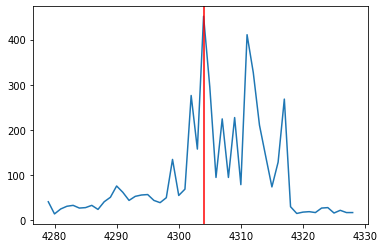

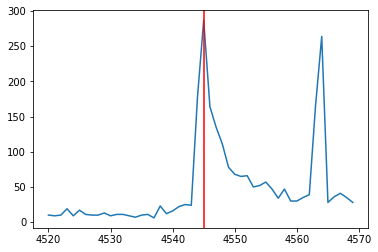

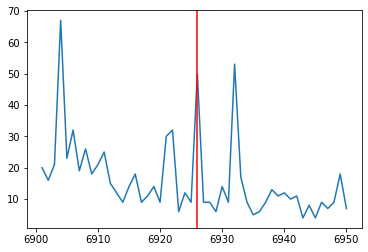

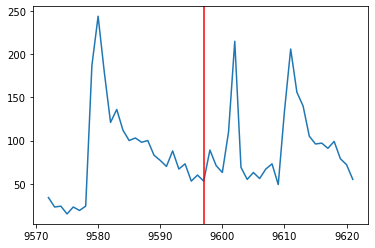

In [14]:
print("Red line shows the anomaly point")
for index in labels[labels==1].index:
    plt.plot(data['value'][index-25:index+25])
    plt.axvline(index, color='red')
    plt.show()

In [15]:
# test data at least 90 %, possibly more after transfering anomalies to it
split_point = int(0.9 * len(data))
train_data = data.iloc[:split_point,:].copy()
test_data = data.iloc[split_point:,:].copy()

In [16]:
len(train_data)

14257

In [19]:
# new empty dataframes with the same structure + added id column
data['id'] = 0
new_train_df = data.iloc[0:0,:].copy()
new_test_df = data.iloc[0:0,:].copy()

# id counter to prevent disjoint series clumped together
next_id = 0
# lower and upper end of the anomalous series, needed for proper split 
low = 0
high = 0

# removing anomalies from training data and placing them to the test set (separated by ids) 
for index in train_data[train_data['anomaly']==1].index:
    # calculate start of anomalous series
    low = max(0,index-ANOMALY_CONTEXT)
    # use previous anomaly upper interval index 
    # to preserve non-anomalous data in the training set
    anomaly_free_df = train_data[high:low].copy()
    # update the boundary
    high = min(len(train_data),index+ANOMALY_CONTEXT)
    around_anomaly_df = train_data[low:high].copy()
    # set ids
    anomaly_free_df['id'] = next_id
    around_anomaly_df['id'] = next_id
    next_id += 1
    new_train_df = pd.concat([new_train_df,anomaly_free_df])
    new_test_df = pd.concat([new_test_df,around_anomaly_df])

# rest of data (no anomalies) 
anomaly_free_df = train_data[high:].copy()
anomaly_free_df['id'] = next_id
# original test data, supply it with last unused test id
test_data['id'] = next_id
new_train_df = pd.concat([new_train_df,anomaly_free_df])
new_test_df = pd.concat([new_test_df,test_data])


In [25]:
new_test_df[new_test_df['anomaly']==1]

,value,anomaly,id
4304,452,1,0
4545,287,1,1
6926,50,1,2
9597,53,1,3


## MSE anomaly score

Anomaly score calculated using average MSE of 100 reconstructed samples against the real time-window. The higher the value, the more significant anomaly detected.

In [ ]:
scvae = SCVAEDetector(latent_dim=4,time_window=16,batch_size=64,id_columns=[])
scvae.fit(train_data, learning_rate = 0.001, epochs=100)
    
# might take a while :) we generate 100 samples in each shift of the rolling time window
test_res = scvae.predict_anomaly_scores(test_data)

## Test data

As we can see, anomaly score correlates nicely with higher anomalous traffic in twitter data.

Please note that anomaly score for a particular data point is influenced by all time windows containing the sample. This effectively leads to the anomaly score seeing both into the future and past by a half of the time window.

In [ ]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(test_data[500:1500]), alpha=0.5, label='scaled data')
plt.plot(np.array(test_res[500:1500]), lw=5, c='red', label='anomaly score')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-1,15)